<a href="https://colab.research.google.com/github/r-dube/fakejobs/blob/main/fj_composite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the modules used
import numpy as np
import pandas as pd
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Conv1D, MaxPool1D, Flatten, RepeatVector, Input, Embedding, Concatenate
from keras.optimizers import Adam
from keras import metrics
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [2]:
# For reproducible results, set seeds
import random as rn
import os
import tensorflow as tf
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [3]:
# Set data_url, the location of the data
# Data is not loaded from a local file
# data_url="https://raw.githubusercontent.com/r-dube/fakejobs/main/data/fj_small.csv"
# data_url="https://raw.githubusercontent.com/r-dube/fakejobs/main/data/fj_medium.csv"
data_url="https://raw.githubusercontent.com/r-dube/fakejobs/main/data/fake_job_postings.csv"

In [4]:
def fj_load_df_from_url():
    """
    Load dataframe from csv file
    Input:
        None
    Returns:
        dataframe
    """

    df = pd.read_csv(data_url)

    print ('Loaded dataframe shape', df.shape)

    counts = fj_label_stats(df)
    print ('Not fraudulent', counts[0], 'Fraudulent', counts[1])

    print(df.describe())

    print ('NAs/NANs in data =>')
    print(df.isna().sum())

    return df

def fj_label_stats(df):
    """
    Very basic label statistics
    Input: 
        Dataframe
    Returns:
        Number of samples with 0, 1 as the label
    """
    counts = np.bincount(df['fraudulent'])
    return counts

def fj_txt_only(df):
    """
    Combine all the text fields, discard everything else except for the label
    Input: 
        Dataframe
    Returns:
        Processed dataframe
    """
    
    df.fillna(" ", inplace = True)

    df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + \
    ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + \
    df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + \
    ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function'] 

    del df['title']
    del df['location']
    del df['department']
    del df['company_profile']
    del df['description']
    del df['requirements']
    del df['benefits']
    del df['employment_type']
    del df['required_experience']
    del df['required_education']
    del df['industry']
    del df['function']  
    
    del df['salary_range']
    del df['job_id']
    del df['telecommuting']
    del df['has_company_logo']
    del df['has_questions']

    return df

In [5]:
df = fj_load_df_from_url()
df = fj_txt_only(df)
print('Maximum text length', df['text'].str.len().max())

Loaded dataframe shape (17880, 18)
Not fraudulent 17014 Fraudulent 866
             job_id  telecommuting  ...  has_questions    fraudulent
count  17880.000000   17880.000000  ...   17880.000000  17880.000000
mean    8940.500000       0.042897  ...       0.491723      0.048434
std     5161.655742       0.202631  ...       0.499945      0.214688
min        1.000000       0.000000  ...       0.000000      0.000000
25%     4470.750000       0.000000  ...       0.000000      0.000000
50%     8940.500000       0.000000  ...       0.000000      0.000000
75%    13410.250000       0.000000  ...       1.000000      0.000000
max    17880.000000       1.000000  ...       1.000000      1.000000

[8 rows x 5 columns]
NAs/NANs in data =>
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telec

In [6]:
# Utilities to clean text

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [7]:
# more text cleaning - remove stopwords using NLTK
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Actually clean the text
df['text'] = df['text'].map(lambda x: remove_URL(x))
df['text'] = df['text'].map(lambda x: remove_html(x))
df['text'] = df['text'].map(lambda x: remove_emoji(x))
df['text'] = df['text'].map(lambda x: remove_punct(x))
df['text'] = df["text"].map(remove_stopwords)

In [9]:
# train-test split
train_text, test_text, train_labels , test_labels = train_test_split(df['text'], df['fraudulent'] , test_size = 0.15)
print(train_text.shape)

(15198,)


In [10]:
# Token model: Configuration parameters
max_num_words = 50000 # maximum allowed size of vocabulary
max_length = 250 # maximum allowed number of words in a job description
embed_dim = 32 # number of dimensions for learned embedding

In [11]:
# Token Model: Prepare the token based train and test input

# max_num_words variable in case we want to clip the number of words
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_text)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)

test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)

print(f"Shape of train {train_padded.shape}")
print(f"Shape of test {test_padded.shape}")

Shape of train (15198, 250)
Shape of test (2682, 250)


In [12]:
# Char model: Configuration parameters

# Assuming that the text has been processed for word tokenization
# alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
alphabet="abcdefghijklmnopqrstuvwxyz0123456789"
encoding_size = len(alphabet)
char_input_size=1000

# Create a dictionary for encoding characters
dict = {}  # Maps each character to an integer
for idx, char in enumerate(alphabet):
  dict[char] = idx + 1

print(encoding_size)
print (dict)

36
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36}


In [13]:
# Char model: Utility function(s)

# Return one-hot-vector character encoding for string
# Memory is allocated outside this routine
def str_to_ohv(s, ohv):
  max_length = min(len(s), char_input_size)
  for i in range(0, max_length):
    c = s[i]
    if c in dict:
      ohv[i, dict[c]-1] = 1
  return ohv

In [14]:
# Char model: create train input
num_jobs = train_text.shape[0]
train_t = np.zeros((num_jobs, char_input_size, encoding_size), dtype=np.int8)
i = 0
for _, val in train_text.iteritems():
  str_to_ohv(val, train_t[i])
  i=i+1

In [15]:
# Char model: create test input
num_jobs = test_text.shape[0]
test_t = np.zeros((num_jobs, char_input_size, encoding_size), dtype=np.int8)
i = 0
for _, val in test_text.iteritems():
  str_to_ohv(val, test_t[i])
  i=i+1

In [16]:
# The Composite model: Token + Char

# Not specificying input dtype as Keras internally assumes float32

# Token (word) model
token_input = Input(shape=(max_length,), name="token_input")
token_embedding = Embedding(max_num_words, embed_dim, input_length=max_length, name="token_embedding")(token_input)
token_conv = Conv1D(64, kernel_size=3, strides=1, padding="valid", activation="relu", name="token_conv")(token_embedding)
token_pool = MaxPool1D(pool_size=3, strides=3, name="token_pool")(token_conv)
token_drop = Dropout(.5, name="token_drop")(token_pool)

# Char model
char_input = Input(shape=(char_input_size, encoding_size), name="char_input")
char_conv = Conv1D(64, kernel_size=3, strides=1, padding="valid",activation="relu", name="char_conv")(char_input)
char_pool = GlobalMaxPool1D(name="char_pool")(char_conv)
char_drop = Dropout(.5, name="char_drop")(char_pool)
char_repeated = RepeatVector(2, name="char_repeated")(char_drop)

# Merge
merged = Concatenate(axis=1, name="concat")([token_drop, char_repeated])
lstm = Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.01, name="lstm"), name="bidir")(merged)
output = Dense(1, activation="sigmoid", name="output")(lstm)

# define a model with a list of two inputs
model = Model(inputs=[token_input, char_input], outputs=output)

In [17]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy', tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_input (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
char_input (InputLayer)         [(None, 1000, 36)]   0                                            
__________________________________________________________________________________________________
token_embedding (Embedding)     (None, 250, 32)      1600000     token_input[0][0]                
__________________________________________________________________________________________________
char_conv (Conv1D)              (None, 998, 64)      6976        char_input[0][0]                 
______________________________________________________________________________________________

In [18]:
model.fit([train_padded, train_t], train_labels, epochs = 7)

Epoch 1/7
475/475 [==============================] - 125s 248ms/step - loss: 0.2032 - accuracy: 0.9334 - false_positives: 58.9034 - false_negatives: 305.3845
Epoch 2/7
475/475 [==============================] - 118s 248ms/step - loss: 0.0292 - accuracy: 0.9909 - false_positives: 23.1891 - false_negatives: 41.8571
Epoch 3/7
475/475 [==============================] - 117s 245ms/step - loss: 0.0089 - accuracy: 0.9975 - false_positives: 9.0651 - false_negatives: 10.2269
Epoch 4/7
475/475 [==============================] - 117s 245ms/step - loss: 0.0050 - accuracy: 0.9986 - false_positives: 4.9034 - false_negatives: 6.3739
Epoch 5/7
475/475 [==============================] - 117s 246ms/step - loss: 8.8857e-04 - accuracy: 0.9998 - false_positives: 0.3403 - false_negatives: 1.7878
Epoch 6/7
475/475 [==============================] - 116s 245ms/step - loss: 3.0083e-04 - accuracy: 1.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7/7
475/475 [=============================

In [19]:
pred_soft = model.predict([test_padded, test_t])

In [20]:
# pred = np.around(pred_soft, decimals = 0)
pred = np.where(pred_soft > 0.15, 1, 0)

acc = accuracy_score(pred, test_labels)
f1 = f1_score(pred, test_labels)

cm = confusion_matrix(test_labels, pred)
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]

print('Accuracy score: {:.4f}'.format(acc), 'F1 score: {:.4f}'.format(f1))
print('False Positives: {:.0f}'.format(fp), 'False Negatives: {:.0f}'.format(fn))
print('Confusion matrix:\n', cm)

Accuracy score: 0.9828 F1 score: 0.8284
False Positives: 13 False Negatives: 33
Confusion matrix:
 [[2525   13]
 [  33  111]]


In [21]:
auc = roc_auc_score(test_labels, pred_soft)
print('AUC score: {:.4f}'.format(auc))

AUC score: 0.9767


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


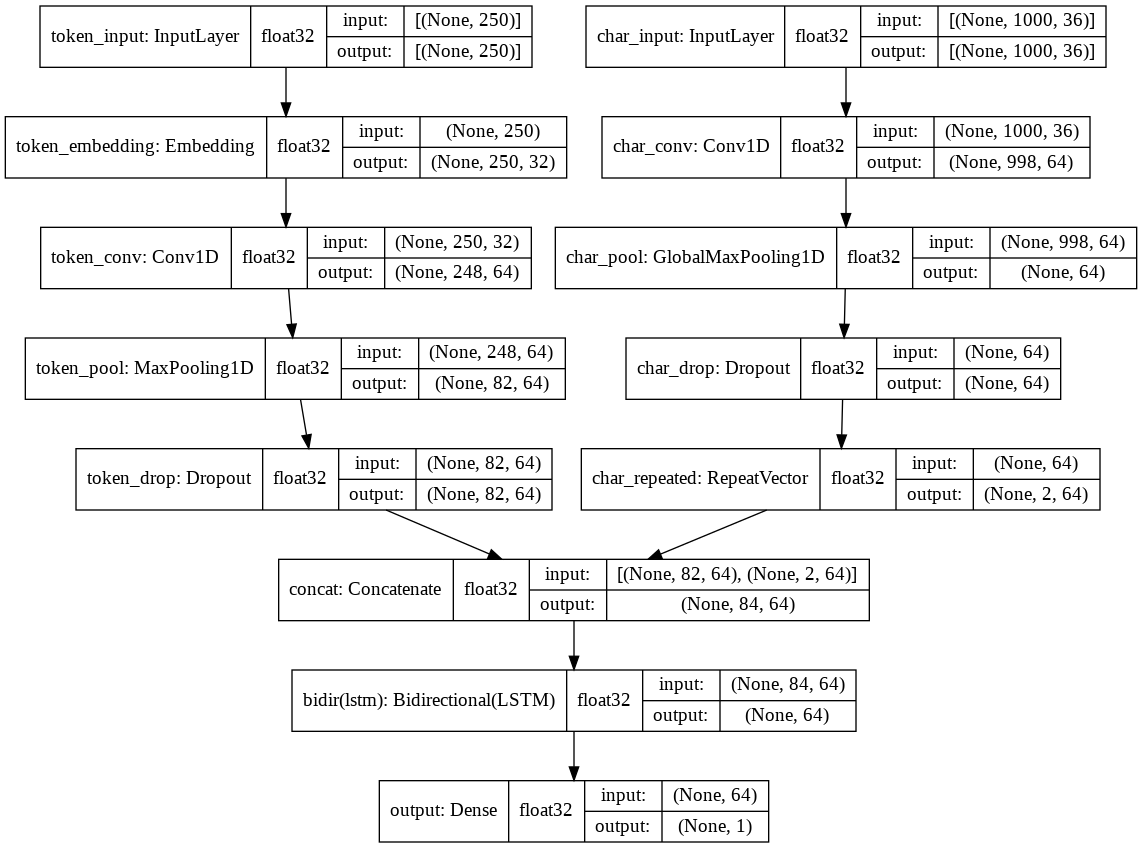

In [22]:
# Uncomment to save image of model architecture
from google.colab import drive
drive.mount('/content/drive')

dot_img_file = '/content/drive/My Drive/Results/fj_composite.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_dtype=True)